In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/mode_choice')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2017
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [2]:
#load modeled, FAF and CFS results
faf_data = read_csv(c.input_dir + c.faf_version_4_file, sep = ',')
cfs_distribution = read_csv(c.input_dir + c.cfs_dir + c.cfs_distribution_file, sep = ',')
modeled_data = read_csv(c.output_dir + c.modeled_file, sep = ',')
modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']
#load parameters
sctg_group_lookup = read_csv(c.param_dir + c.sctg_group_lookup_file, sep = ',')
mesozone_lookup = read_csv(c.param_dir + c.mesozone_id_lookup_file, sep = ',')
sctg_definition = read_csv(c.param_dir + c.sctg_definition_file, sep = ',')
sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

In [3]:
# process faf data for validation
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == c.trade_type_id] #select domestic shipment only
bay_area_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(c.region_code)]
bay_area_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(c.region_code)]
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2012,...,wgt_dist,mode_def,SCTG,Description_x,SCTG_Code,SCTG_Group,SCTG_Name,Description_y,Unnamed: 4,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,17.3922,...,18.6118,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),NaN,18.609217
1,NaN,11,19,NaN,NaN,1,NaN,1,1,220.0650,...,115.3641,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),NaN,115.364254
2,NaN,11,129,NaN,NaN,1,NaN,1,1,1.0854,...,626.3129,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),NaN,626.281940
3,NaN,11,131,NaN,NaN,1,NaN,1,1,6.1655,...,256.8973,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),NaN,256.904175
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2.7483,...,316.7413,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),NaN,316.743324


In [4]:
### process CFS data
unique_region_names = mesozone_lookup.loc[mesozone_lookup['FAFID'].isin(c.region_code), 'FAFNAME'].unique()
cfs_distribution = pd.merge(cfs_distribution, sctg_group_definition, left_on = 'commodity', right_on = 'SCTG_Name', how = 'left')
cfs_distribution.loc[:, 'tonmile'] = 1000 * cfs_distribution.loc[:, 'wgted_wght_ton_th'] * cfs_distribution.loc[:, 'SHIPMT_DIST_GC']
cfs_distribution_by_zone = cfs_distribution.groupby(['ORIG_NAME', 'DEST_NAME', 'commodity', 'SCTG_Group', 'mode_agg5'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_distribution_by_zone = cfs_distribution_by_zone.reset_index()
cfs_distribution_by_zone.loc[:, 'SHIPMT_DIST_GC'] = cfs_distribution_by_zone.loc[:, 'tonmile'] / cfs_distribution_by_zone.loc[:, 'wgted_wght_ton_th'] / 1000
cfs_inflow = cfs_distribution_by_zone.loc[cfs_distribution_by_zone['DEST_NAME'].isin(unique_region_names)] 
cfs_outflow = cfs_distribution_by_zone.loc[cfs_distribution_by_zone['ORIG_NAME'].isin(unique_region_names)] 
cfs_distribution.head(5)

,WGT_FACTOR,ORIG_CFS_AREA,ORIG_NAME,DEST_CFS_AREA,DEST_NAME,SHIPMT_DIST_GC,commodity,naics_name,wght_ton_th,wgted_wght_ton_th,mode_agg5,SCTG_Group,SCTG_Name,tonmile
0,18201.7,48-12420,Austin,36-160,Buffalo,1348,mfr_goods,Retail,2.000000e-06,0.036403,Parcel,4,mfr_goods,49071.78320
1,566.8,17-176,Chicago (IL),48-41700,San Antonio,1057,mfr_goods,Manufacturing,1.900000e-05,0.010769,Parcel,4,mfr_goods,11383.04440
2,121.0,48-206,Dallas,48-99999,Rest of TX,466,mfr_goods,Manufacturing,3.420000e-04,0.041382,For-hire Truck,4,mfr_goods,19284.01200
3,551.7,13-122,Atlanta,48-99999,Rest of TX,729,mfr_goods,Wholesale,5.000000e-07,0.000276,Parcel,4,mfr_goods,201.09465
4,57.3,48-99999,Rest of TX,48-99999,Rest of TX,180,bulk,Wholesale,6.928850e-02,3.970231,Rail/IMX,1,bulk,714641.58900


In [6]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
modeled_bay_area_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
modeled_bay_area_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11,Birmingham,481,Austin,4,mfr_goods,For-hire Truck,280051.482297,0.326492,109,0,1,857.760000
1,1,11,Birmingham,481,Austin,4,mfr_goods,Parcel,985827.658937,1.451039,484,0,1,679.394153
2,2,11,Birmingham,481,Austin,4,mfr_goods,Rail/IMX,2993.681784,0.003009,1,0,1,994.940199
3,3,11,Birmingham,488,San Antonio,2,fuel_fert,For-hire Truck,15590.131740,0.016463,2,0,1,946.980000
4,4,11,Birmingham,488,San Antonio,4,mfr_goods,For-hire Truck,130159.626045,0.137447,46,0,1,946.980000


interm_food


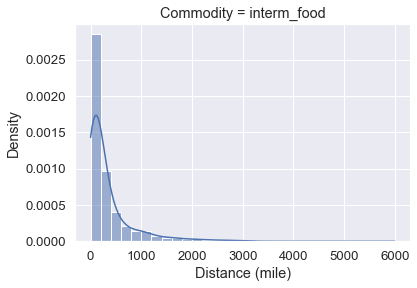

bulk


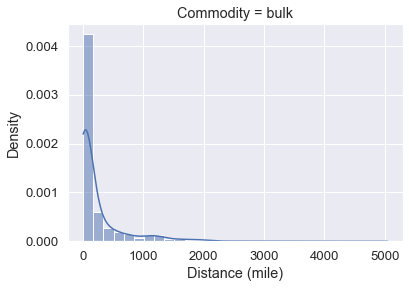

mfr_goods


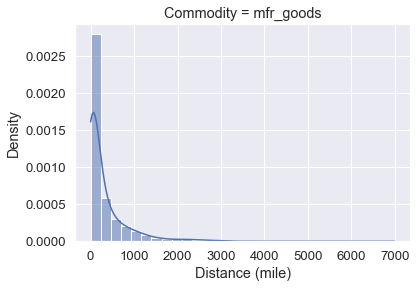

fuel_fert


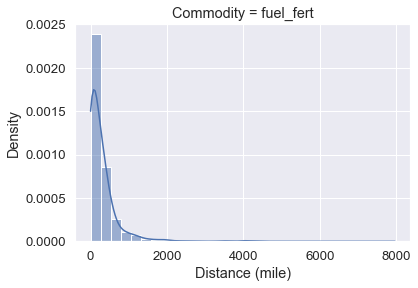

other


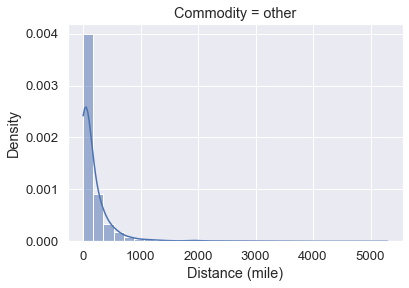

In [7]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('plot/distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(c.output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck


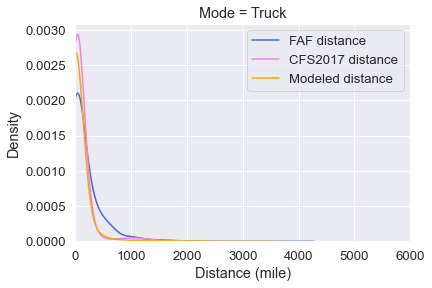

Rail


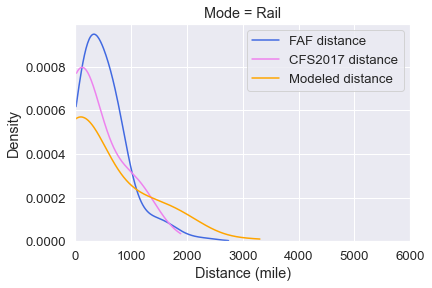

Air


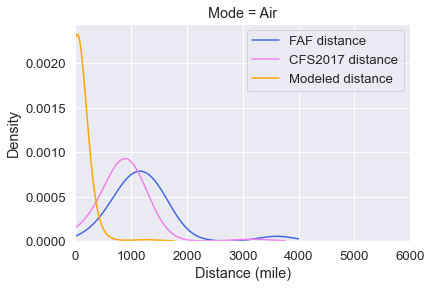

Parcel


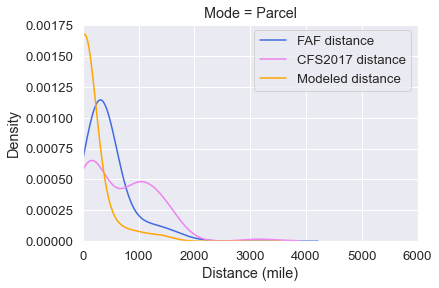

Truck


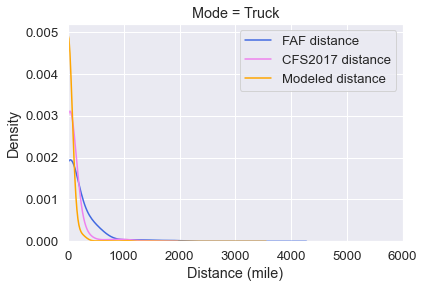

Rail


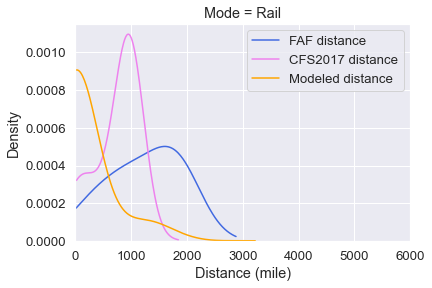

Air


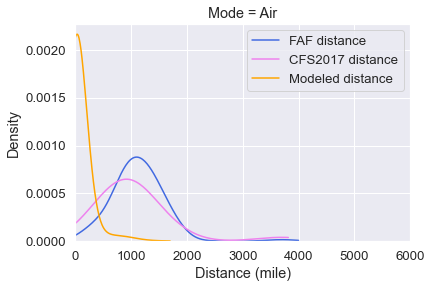

Parcel


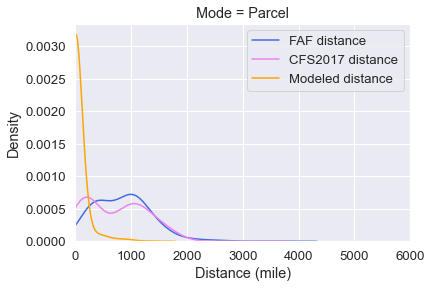

In [8]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}
CFS_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    cfs_data_to_describe = cfs_outflow.loc[cfs_outflow['mode_agg5'].isin(mode_to_select)]
    modeled_data_to_describe = modeled_bay_area_outflow.loc[modeled_bay_area_outflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_outflow.loc[bay_area_outflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')    
    sns.kdeplot(data = cfs_data_to_describe, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
            color = 'violet')    
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('plot/outflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_outflow_distance_statistics_by_mode.csv')

# attraction
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    cfs_data_to_describe = cfs_inflow.loc[cfs_inflow['mode_agg5'].isin(mode_to_select)]
    modeled_data_to_describe = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_inflow.loc[bay_area_inflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
    sns.kdeplot(data = cfs_data_to_describe, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
             color = 'violet') 
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('plot/inflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

FAF tonmile        221287.367600
CFS tonmile         84266.864650
Modeled tonmile     66094.013476
dtype: float64


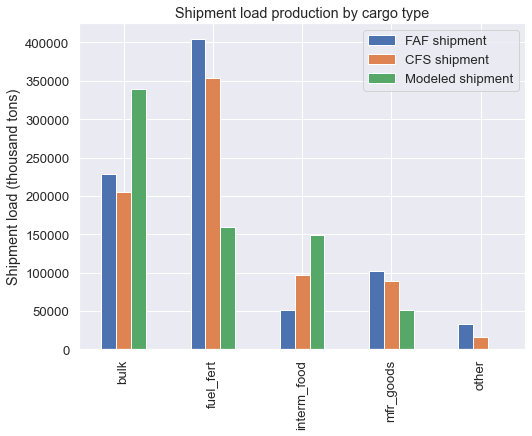

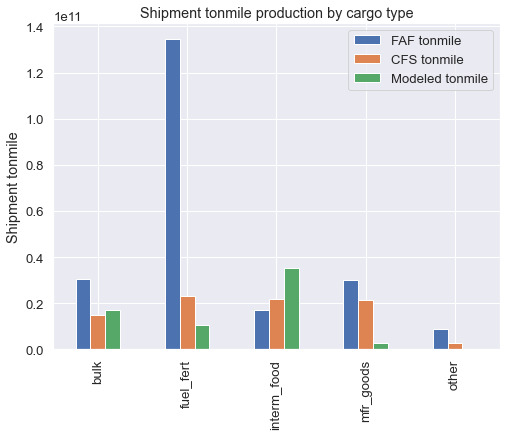

In [9]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = bay_area_outflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
CFS_shipment_by_sctg = cfs_outflow.groupby('commodity')[['wgted_wght_ton_th', 'tonmile']].sum()
modeled_shipment_by_sctg = modeled_bay_area_outflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()
shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, CFS_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg = pd.merge(shipment_generation_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'CFS shipment', 'CFS tonmile',
                                       'Modeled shipment', 'Modeled tonmile']

print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_generation_by_sctg.plot(y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig('Plot/' + 'outflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()


shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig('Plot/' + 'outflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

FAF tonmile        227622.206500
CFS tonmile        163477.790537
Modeled tonmile     21392.614552
dtype: float64


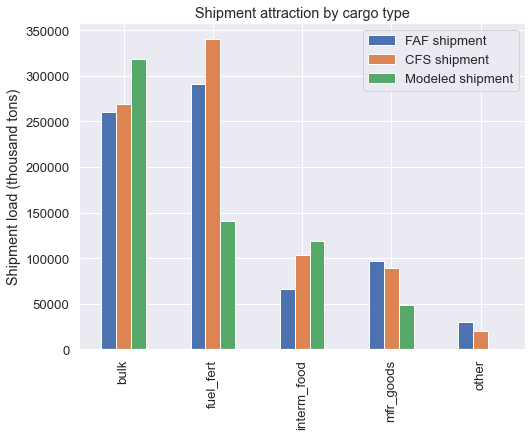

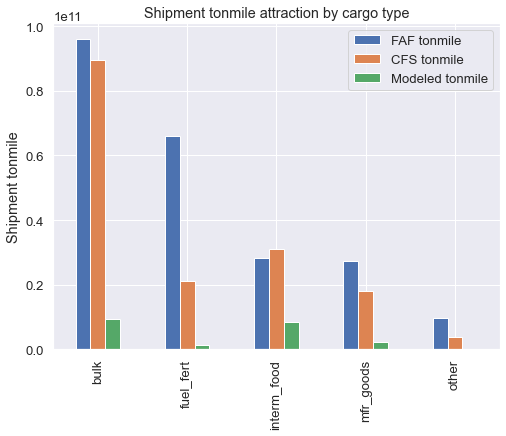

In [10]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = bay_area_inflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
CFS_shipment_by_sctg = cfs_inflow.groupby('commodity')[['wgted_wght_ton_th', 'tonmile']].sum()
modeled_shipment_by_sctg = modeled_bay_area_inflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()
shipment_attraction_by_sctg = pd.merge(FAF_shipment_by_sctg, CFS_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg = pd.merge(shipment_attraction_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'CFS shipment', 'CFS tonmile',
                                       'Modeled shipment', 'Modeled tonmile']
print(shipment_attraction_by_sctg.loc[:, ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_attraction_by_sctg.plot(y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  title = 'Shipment attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig('Plot/' + 'inflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.plot(y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig('Plot/' + 'inflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

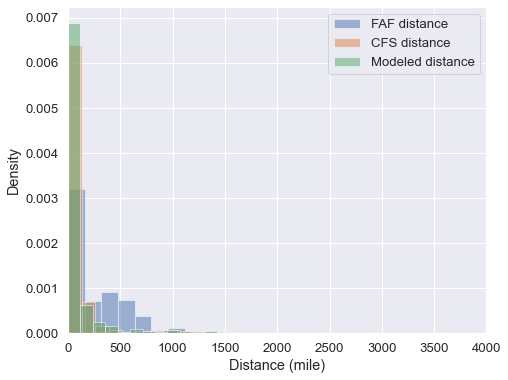

30         84.7226
56         70.0781
121         0.5284
122         0.1699
123         0.3248
            ...   
2854496     0.6303
2854677     0.0922
2854678     0.1220
2854685     0.0573
2854686     0.9347
Name: tons_2017, Length: 11243, dtype: float64


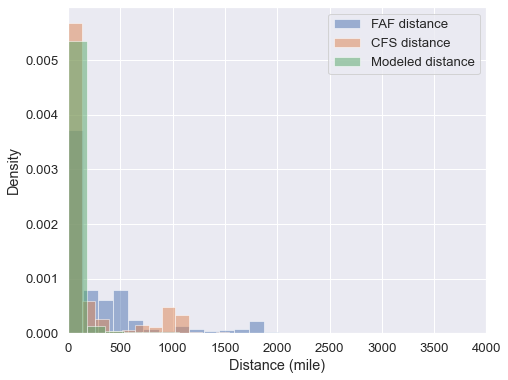

In [10]:
### plot shipment distance distribution
# generation
plt.figure(figsize=(7.5,6))
bay_area_outflow['Distance'].plot(kind = "hist", weights = bay_area_outflow[shipment_load_attr], 
                                  alpha = 0.5, bins = 50, density = True)
cfs_outflow['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_outflow['wgted_wght_ton_th'], 
                                  alpha = 0.5, bins = 30, density = True)
modeled_bay_area_outflow['Distance'].plot(kind = "hist", weights = modeled_bay_area_outflow['ShipmentLoad'], 
                                          alpha = 0.5, bins = 30, density = True)
plt.legend(['FAF distance', 'CFS distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.xlim([0, 4000])
plt.savefig('plot/outflow_distance_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()

# attraction
plt.figure(figsize=(7.5,6))
print(bay_area_inflow[shipment_load_attr])
# bay_area_inflow = bay_area_inflow.dropna(subset = ['Distance', shipment_load_attr])
bay_area_inflow['Distance'].plot(kind = "hist", weights = bay_area_inflow[shipment_load_attr], 
                                  alpha = 0.5, bins = 30, density = True)
cfs_inflow['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_inflow['wgted_wght_ton_th'], 
                                  alpha = 0.5, bins = 30, density = True)
#plt.show()
modeled_bay_area_inflow['Distance'].plot(kind = "hist", weights = modeled_bay_area_inflow['ShipmentLoad'], 
                                          alpha = 0.5, bins = 20, density = True)
plt.legend(['FAF distance', 'CFS distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.xlim([0, 4000])
plt.savefig('plot/inflow_distance_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()

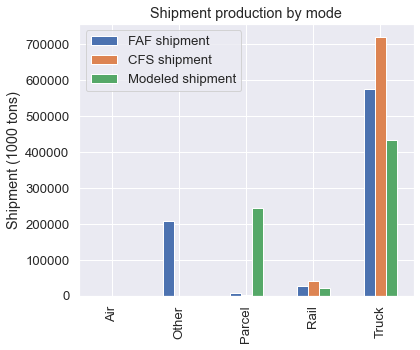

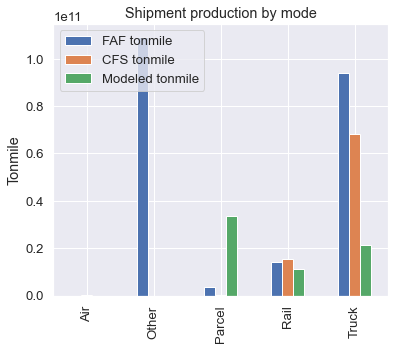

In [11]:
# plot shipment production by mode choice
cfs_outflow.loc[:, 'mode_def'] = cfs_outflow.loc[:, 'mode_agg5'].map(CFS_to_FAF_mapping)
modeled_bay_area_outflow.loc[:, 'mode_def'] = modeled_bay_area_outflow.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
    
agg_faf_outflow_by_mode = bay_area_outflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()
cfs_outflow_by_mode = cfs_outflow.groupby(['mode_def'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_outflow_by_mode = cfs_outflow_by_mode.reset_index()
agg_modeled_outflow_by_mode = modeled_bay_area_outflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_outflow_by_mode = pd.merge(compare_outflow_by_mode, cfs_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile',
                                  'CFS shipment', 'CFS tonmile',]
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Shipment production by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot/' + 'outflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Shipment production by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot/' + 'outflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(c.output_dir + 'outflow_shipment_by_mode_comparison.csv')

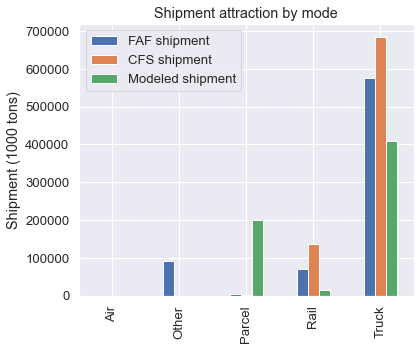

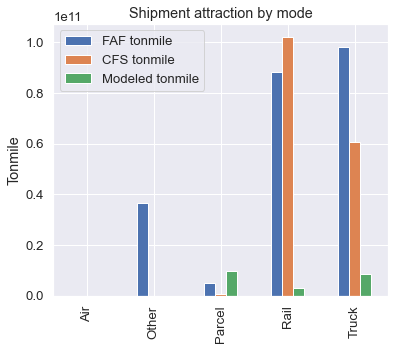

In [12]:
# plot shipment attraction by mode choice
cfs_inflow.loc[:, 'mode_def'] = cfs_inflow.loc[:, 'mode_agg5'].map(CFS_to_FAF_mapping)
modeled_bay_area_inflow.loc[:, 'mode_def'] = modeled_bay_area_inflow.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
    
agg_faf_inflow_by_mode = bay_area_inflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_mode = agg_faf_inflow_by_mode.reset_index()
cfs_inflow_by_mode = cfs_inflow.groupby(['mode_def'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_inflow_by_mode = cfs_inflow_by_mode.reset_index()
agg_modeled_inflow_by_mode = modeled_bay_area_inflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_mode = agg_modeled_inflow_by_mode.reset_index()
compare_inflow_by_mode = pd.merge(agg_faf_inflow_by_mode, agg_modeled_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_inflow_by_mode = pd.merge(compare_inflow_by_mode, cfs_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_inflow_by_mode.head(5)
compare_inflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile',
                                  'CFS shipment', 'CFS tonmile',]
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_mode.plot(x= 'mode_def', 
                            y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Shipment attraction by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot/' + 'inflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_inflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Shipment attraction by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot/' + 'inflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_mode.to_csv(c.output_dir + 'inflow_shipment_by_mode_comparison.csv')

   orig_FAFID orig_FAFNAME   ShipmentLoad
0         481       Austin   75067.572315
1         488  San Antonio   83227.342525
2         489   Rest of TX  540713.716181


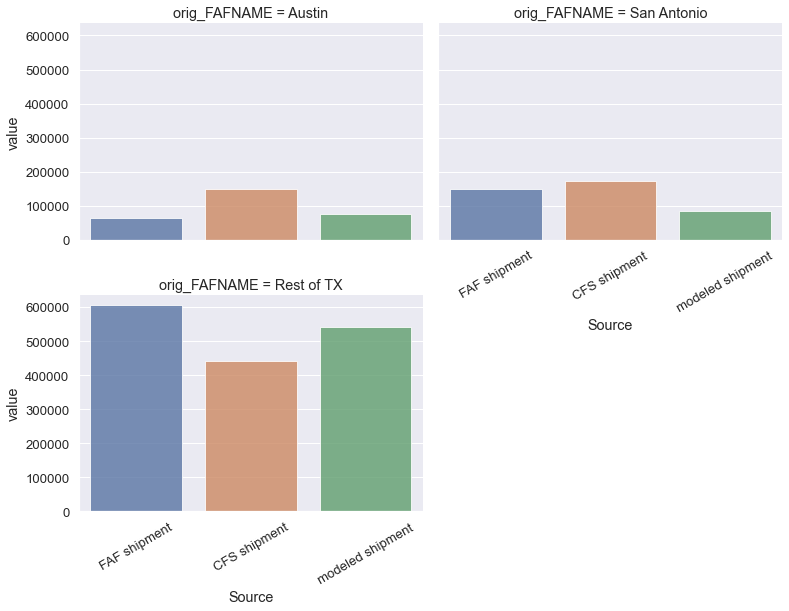

In [13]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_outflow_by_zone = bay_area_outflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_zone = agg_faf_outflow_by_zone.reset_index()
cfs_outflow_by_zone = cfs_outflow.groupby(['ORIG_NAME'])[['wgted_wght_ton_th']].sum()
agg_modeled_outflow_by_zone = modeled_bay_area_outflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_by_zone = agg_modeled_outflow_by_zone.reset_index()
print(agg_modeled_outflow_by_zone)
                                                                      
compare_outflow_by_zone = pd.merge(agg_faf_outflow_by_zone, agg_modeled_outflow_by_zone, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')
compare_outflow_by_zone = pd.merge(compare_outflow_by_zone, cfs_outflow_by_zone, 
                                         left_on = ['orig_FAFNAME'], right_on = ['ORIG_NAME'], how = 'left')
compare_outflow_by_zone = compare_outflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment',
                                                                             'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_zone = pd.melt(compare_outflow_by_zone, 
                                    id_vars=['dms_orig', 'orig_FAFID', 'orig_FAFNAME'], 
                                    value_vars=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                    var_name = 'Source', ignore_index=False)
# print(compare_outflow_by_zone.head(5))
ax = sns.catplot(
    data= compare_outflow_by_zone, kind="bar",
    x="Source", y="value", col = 'orig_FAFNAME', col_wrap=2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot/outflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_zone.to_csv(c.output_dir + 'compare_outflow_by_zone_cfs_dded.csv', sep = ',')

   dest_FAFID dest_FAFNAME   ShipmentLoad
0         481       Austin   80271.676274
1         488  San Antonio   80442.309640
2         489   Rest of TX  465494.734206


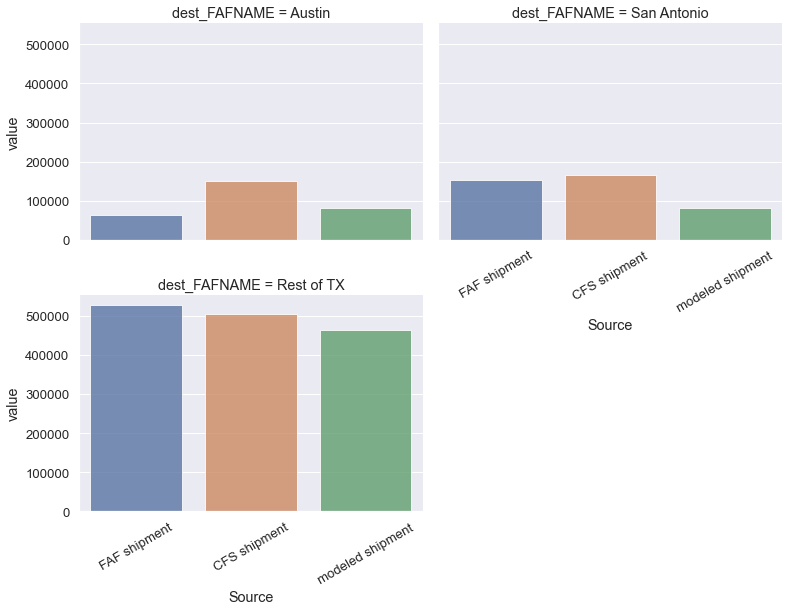

In [14]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_inflow_by_zone = bay_area_inflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_zone = agg_faf_inflow_by_zone.reset_index()
cfs_inflow_by_zone = cfs_inflow.groupby(['DEST_NAME'])[['wgted_wght_ton_th']].sum()
agg_modeled_inflow_by_zone = modeled_bay_area_inflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_by_zone = agg_modeled_inflow_by_zone.reset_index()
print(agg_modeled_inflow_by_zone)
                                                                      
compare_inflow_by_zone = pd.merge(agg_faf_inflow_by_zone, agg_modeled_inflow_by_zone, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')
compare_inflow_by_zone = pd.merge(compare_inflow_by_zone, cfs_inflow_by_zone, 
                                         left_on = ['dest_FAFNAME'], right_on = ['DEST_NAME'], how = 'left')
compare_inflow_by_zone = compare_inflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment',
                                                                             'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_zone = pd.melt(compare_inflow_by_zone, 
                                        id_vars=['dms_dest', 'dest_FAFID', 'dest_FAFNAME'], 
                                        value_vars=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                        var_name = 'Source', ignore_index=False)
# print(compare_inflow_by_zone.head(5))

ax = sns.catplot(
    data= compare_inflow_by_zone, kind="bar",
    x="Source", y="value", col = 'dest_FAFNAME', col_wrap=2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot/inflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_zone.to_csv(c.output_dir + 'compare_inflow_by_zone_cfs_dded.csv', sep = ',')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


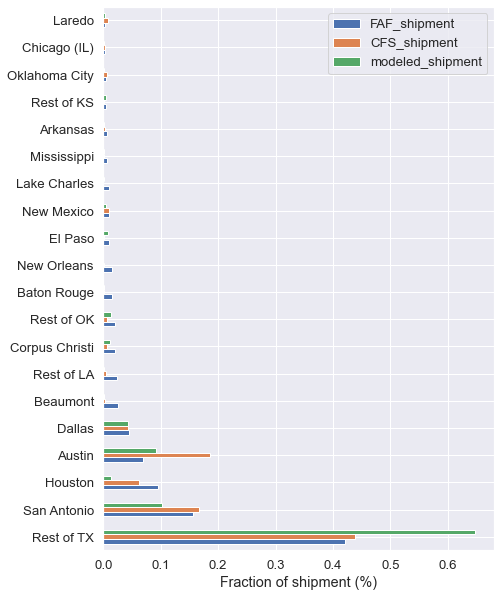

In [15]:
# plot outflow distance and tonnage distribution
nzones = 20
agg_faf_outflow_by_destination = bay_area_outflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_bay_area_outflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()
cfs_outflow_destination = cfs_outflow.groupby(['DEST_NAME'])[['wgted_wght_ton_th']].sum()
                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')

compare_outflow_by_destination = pd.merge(compare_outflow_by_destination, cfs_outflow_destination, 
                                         left_on = ['dest_FAFNAME'], right_on = ['DEST_NAME'], how = 'left')

compare_outflow_by_destination = compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF_shipment', 
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                                'wgted_wght_ton_th':'CFS_shipment'})
compare_outflow_by_destination.loc[:, 'FAF_shipment'] = compare_outflow_by_destination.loc[:, 'FAF_shipment'] / compare_outflow_by_destination.loc[:, 'FAF_shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled_shipment'] = compare_outflow_by_destination.loc[:, 'modeled_shipment'] / compare_outflow_by_destination.loc[:, 'modeled_shipment'].sum()
compare_outflow_by_destination.loc[:, 'CFS_shipment'] = compare_outflow_by_destination.loc[:, 'CFS_shipment'] / compare_outflow_by_destination.loc[:, 'CFS_shipment'].sum()
# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF_shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF_shipment', 'CFS_shipment', 'modeled_shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('plot/percent_outflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [16]:
# Generate distance and tonnage distribution by commodity groups and destinations
agg_faf_outflow_by_destination = bay_area_outflow.groupby(['dms_dest', 'SCTG_Group', \
                                                           'SCTG_Name'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_bay_area_outflow.groupby(['dest_FAFID', 'dest_FAFNAME', \
                                                                    'SCTG_Group', 'SCTG_Name'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

agg_cfs_outflow_destination = cfs_outflow.groupby(['DEST_NAME','SCTG_Group', 'commodity'])[['wgted_wght_ton_th', 'tonmile']].sum()
agg_cfs_outflow_destination = agg_cfs_outflow_destination.reset_index()

compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['dest_FAFID', 'SCTG_Group', 'SCTG_Name'], how = 'left')
compare_outflow_by_destination = pd.merge(compare_outflow_by_destination, agg_cfs_outflow_destination, 
                                         left_on = ['dest_FAFNAME', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['DEST_NAME', 'SCTG_Group', 'commodity'], how = 'left')

compare_outflow_by_destination = compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF_shipment',
                                                                                shipment_tonmile_attr:'FAF_tonmile',
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                               'tmiles': 'modeled_tonmile',
                                                                               'wgted_wght_ton_th': 'CFS_shipment', 
                                                                                'tonmile':'CFS_tonmile'})
compare_outflow_by_destination.loc[:, 'FAF_avg_dist'] = 1000 * compare_outflow_by_destination.loc[:, 'FAF_tonmile'] / \
compare_outflow_by_destination.loc[:, 'FAF_shipment'] 
compare_outflow_by_destination.loc[:, 'CFS_avg_dist'] = compare_outflow_by_destination.loc[:, 'CFS_tonmile'] / \
compare_outflow_by_destination.loc[:, 'CFS_shipment'] 
compare_outflow_by_destination.loc[:, 'Modeled_avg_dist'] = compare_outflow_by_destination.loc[:, 'modeled_tonmile'] / \
compare_outflow_by_destination.loc[:, 'modeled_shipment'] / 1000 
compare_outflow_by_destination.loc[:, 'modeled_tonmile'] /= 1000000 # 1 million tmile
compare_outflow_by_destination.to_csv(c.output_dir + 'compare_distribution_by_destination_cargo.csv', 
                                      sep = ',', index = False)


interm_food


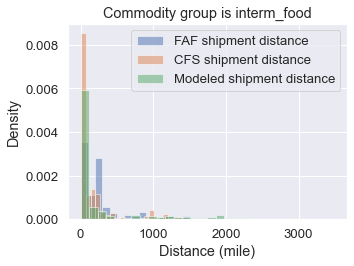

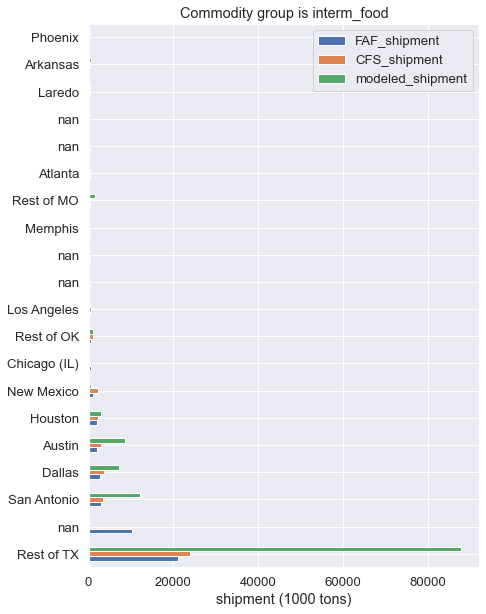

bulk


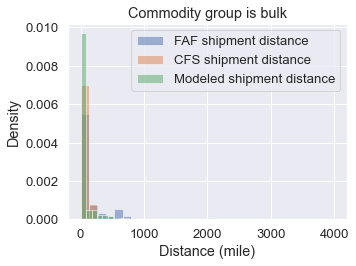

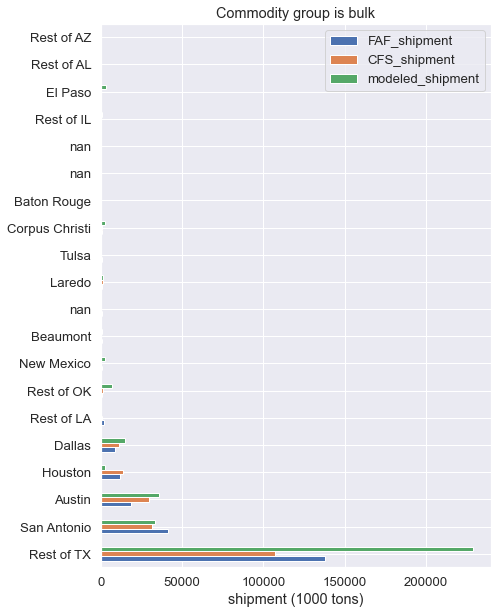

mfr_goods


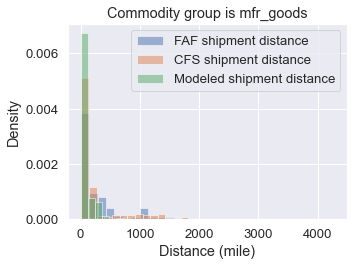

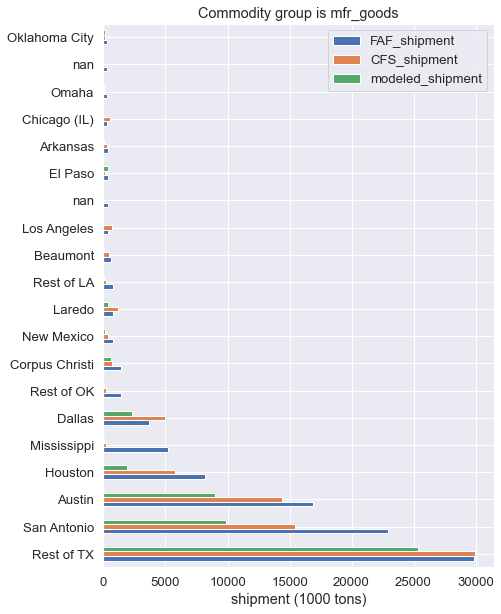

fuel_fert


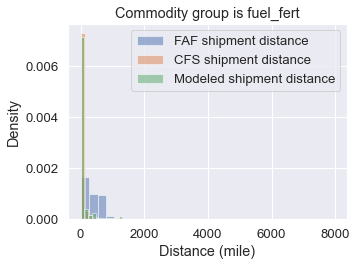

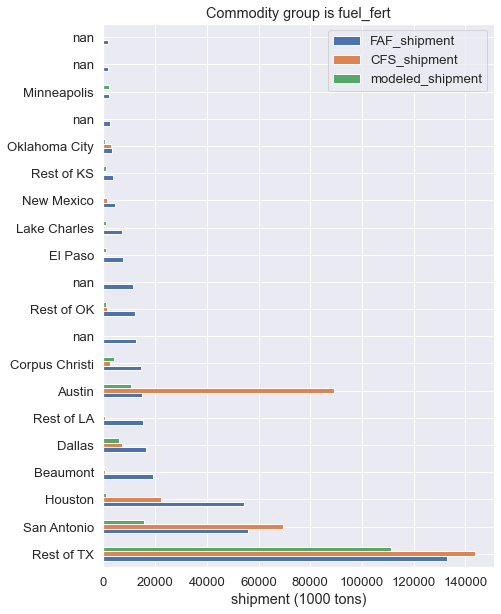

other


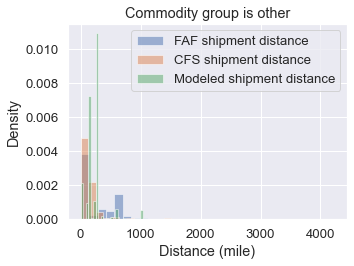

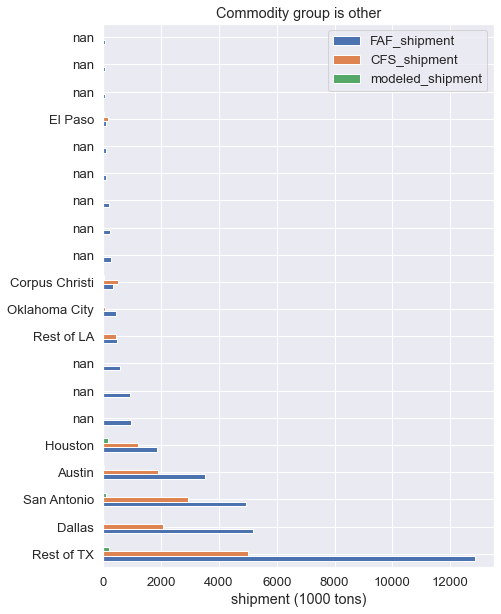

In [18]:
# plot outflow distance and tonnage distribution by commodity groups
nzones = 20
for sctg in sctg_names:
    print(sctg)
    plt.figure(figsize=(5,3.6))
    bay_area_outflow_by_sctg = bay_area_outflow.loc[bay_area_outflow['SCTG_Name'] == sctg]
    bay_area_outflow_by_sctg['Distance'].plot(kind = "hist", weights = bay_area_outflow_by_sctg[shipment_load_attr], 
                                      alpha = 0.5, bins = 30, density=True)
    cfs_outflow_by_sctg = cfs_outflow.loc[cfs_outflow['commodity'] == sctg]
    cfs_outflow_by_sctg['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_outflow_by_sctg['wgted_wght_ton_th'], 
                                      alpha = 0.5, bins = 30, density=True)
    modeled_bay_area_outflow_by_sctg = modeled_bay_area_outflow.loc[modeled_bay_area_outflow['SCTG_Name'] == sctg]
    modeled_bay_area_outflow_by_sctg['Distance'].plot(kind="hist", weights = modeled_bay_area_outflow_by_sctg['ShipmentLoad'], 
                                              alpha =0.5, bins = 30, density=True)
    plt.legend(['FAF shipment distance', 'CFS shipment distance', 'Modeled shipment distance'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.title('Commodity group is ' + sctg)
    plt.savefig('plot/outflow_distance_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    # plot load assignment (top 10 zones)
    compare_outflow_by_destination_sctg = compare_outflow_by_destination.loc[compare_outflow_by_destination['SCTG_Name'] == sctg]
    compare_outflow_by_destination_sctg = compare_outflow_by_destination_sctg.sort_values('FAF_shipment', ascending = False)
    compare_outflow_by_destination_to_plot = compare_outflow_by_destination_sctg.head(nzones)
    compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF_shipment','CFS_shipment', 'modeled_shipment'], 
                                             figsize = (7,10), rot = 0)
    plt.xlabel('shipment (1000 tons)')
    plt.ylabel('')
    plt.title('Commodity group is ' + sctg)           
    plt.savefig('plot/outflow_load_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()

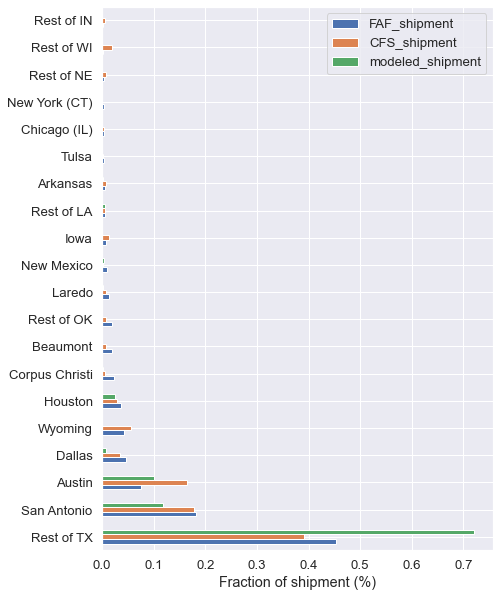

In [17]:
# plot inflow distance and tonnage distribution
nzones = 20
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()
cfs_inflow_destination = cfs_inflow.groupby(['ORIG_NAME'])[['wgted_wght_ton_th']].sum()
                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')

compare_inflow_by_origin = pd.merge(compare_inflow_by_origin, cfs_inflow_destination, 
                                         left_on = ['orig_FAFNAME'], right_on = ['ORIG_NAME'], how = 'left')

compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF_shipment', 
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                                'wgted_wght_ton_th':'CFS_shipment'})


compare_inflow_by_origin.loc[:, 'FAF_shipment'] = compare_inflow_by_origin.loc[:, 'FAF_shipment'] / compare_inflow_by_origin.loc[:, 'FAF_shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled_shipment'] = compare_inflow_by_origin.loc[:, 'modeled_shipment'] / compare_inflow_by_origin.loc[:, 'modeled_shipment'].sum()
compare_inflow_by_origin.loc[:, 'CFS_shipment'] = compare_inflow_by_origin.loc[:, 'CFS_shipment'] / compare_inflow_by_origin.loc[:, 'CFS_shipment'].sum()
# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF_shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF_shipment', 'CFS_shipment', 'modeled_shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('plot/percent_inflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [20]:
# Generate distance and tonnage distribution by commodity groups and origins
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig', 'SCTG_Group', \
                                                           'SCTG_Name'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME', \
                                                                    'SCTG_Group', 'SCTG_Name'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

agg_cfs_inflow_origin = cfs_inflow.groupby(['ORIG_NAME','SCTG_Group', 'commodity'])[['wgted_wght_ton_th', 'tonmile']].sum()
agg_cfs_inflow_origin = agg_cfs_inflow_origin.reset_index()

compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['orig_FAFID', 'SCTG_Group', 'SCTG_Name'], how = 'left')
compare_inflow_by_origin = pd.merge(compare_inflow_by_origin, agg_cfs_inflow_origin, 
                                         left_on = ['orig_FAFNAME', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['ORIG_NAME', 'SCTG_Group', 'commodity'], how = 'left')

compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF_shipment',
                                                                                shipment_tonmile_attr:'FAF_tonmile',
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                               'tmiles': 'modeled_tonmile',
                                                                               'wgted_wght_ton_th': 'CFS_shipment', 
                                                                                'tonmile':'CFS_tonmile'})
compare_inflow_by_origin.loc[:, 'FAF_avg_dist'] = 1000 * compare_inflow_by_origin.loc[:, 'FAF_tonmile'] / \
compare_inflow_by_origin.loc[:, 'FAF_shipment'] 
compare_inflow_by_origin.loc[:, 'CFS_avg_dist'] = compare_inflow_by_origin.loc[:, 'CFS_tonmile'] / \
compare_inflow_by_origin.loc[:, 'CFS_shipment'] 
compare_inflow_by_origin.loc[:, 'Modeled_avg_dist'] = compare_inflow_by_origin.loc[:, 'modeled_tonmile'] / \
compare_inflow_by_origin.loc[:, 'modeled_shipment'] / 1000 
compare_inflow_by_origin.loc[:, 'modeled_tonmile'] /= 1000000 # 1 million tmile
compare_inflow_by_origin.to_csv(c.output_dir + 'compare_distribution_by_origin_cargo.csv', 
                                      sep = ',', index = False)

interm_food


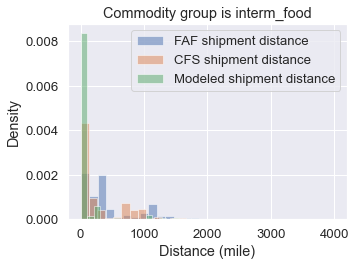

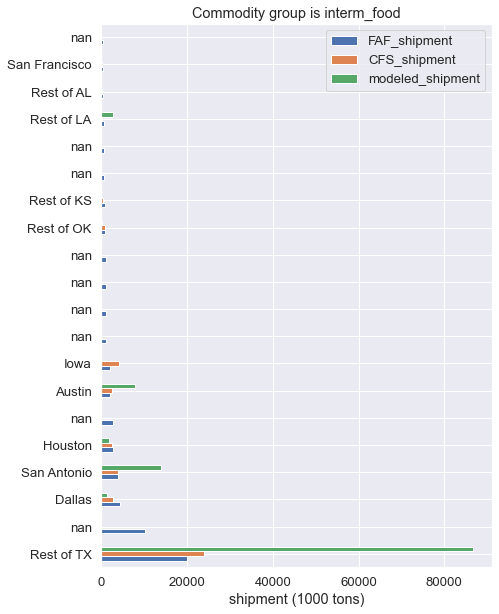

bulk


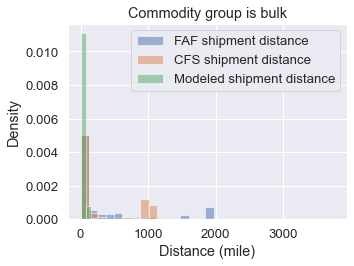

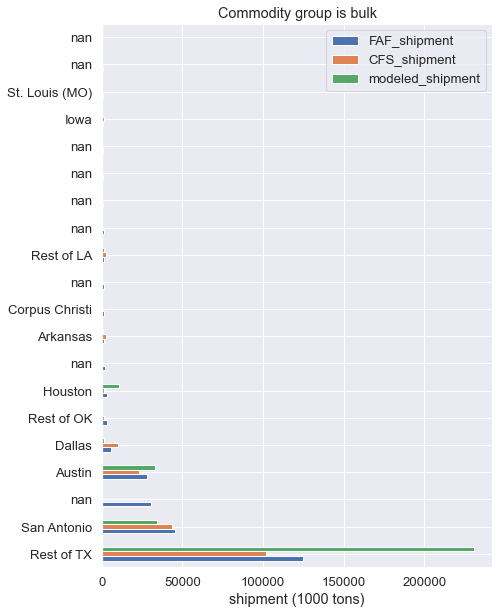

mfr_goods


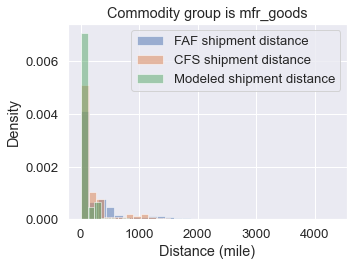

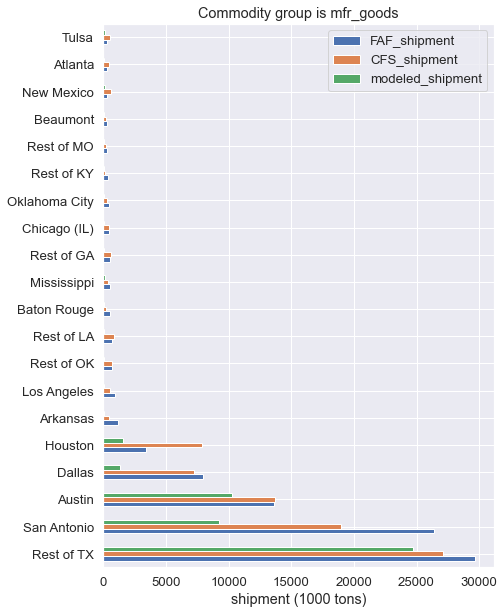

fuel_fert


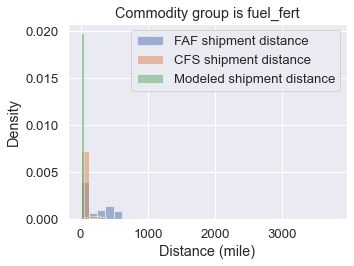

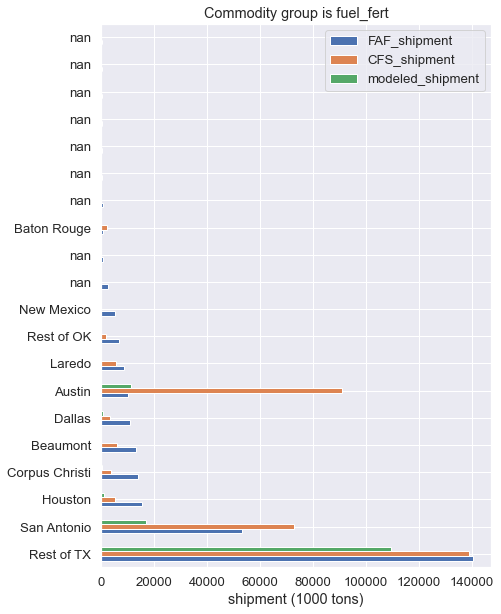

other


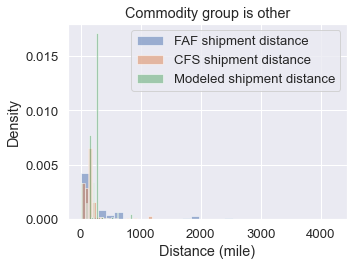

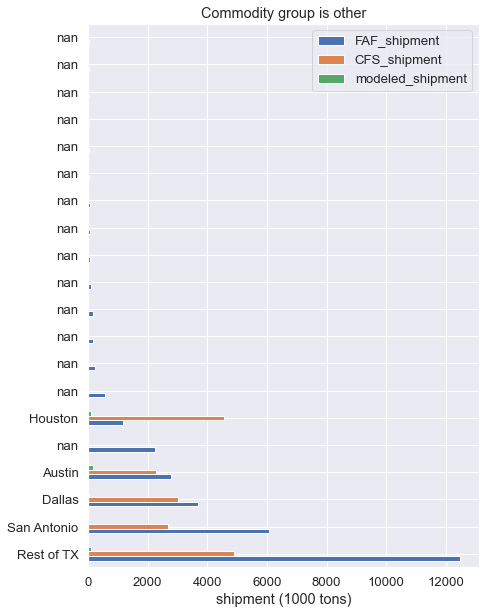

In [21]:
# plot inflow distance and tonnage distribution by commodity groups
for sctg in sctg_names:
    print(sctg)
    plt.figure(figsize=(5,3.6))
    bay_area_inflow_by_sctg = bay_area_inflow.loc[bay_area_inflow['SCTG_Name'] == sctg]
    bay_area_inflow_by_sctg['Distance'].plot(kind = "hist", weights = bay_area_inflow_by_sctg[shipment_load_attr], 
                                      alpha = 0.5, bins = 30, density=True)
    cfs_inflow_by_sctg = cfs_inflow.loc[cfs_inflow['commodity'] == sctg]
    cfs_inflow_by_sctg['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_inflow_by_sctg['wgted_wght_ton_th'], 
                                      alpha = 0.5, bins = 30, density=True)
    modeled_bay_area_inflow_by_sctg = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['SCTG_Name'] == sctg]
    modeled_bay_area_inflow_by_sctg['Distance'].plot(kind="hist", weights = modeled_bay_area_inflow_by_sctg['ShipmentLoad'], 
                                              alpha =0.5, bins = 30, density=True)
    plt.legend(['FAF shipment distance', 'CFS shipment distance', 'Modeled shipment distance'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.title('Commodity group is ' + sctg)
    plt.savefig('plot/inflow_distance_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    # plot load assignment (top 10 zones)
    compare_inflow_by_origin_sctg = compare_inflow_by_origin.loc[compare_inflow_by_origin['SCTG_Name'] == sctg]
    compare_inflow_by_origin_sctg = compare_inflow_by_origin_sctg.sort_values('FAF_shipment', ascending = False)
    compare_inflow_by_origin_sctg_to_plot = compare_inflow_by_origin_sctg.head(nzones)
    compare_inflow_by_origin_sctg_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF_shipment','CFS_shipment', 'modeled_shipment'], 
                                             figsize = (7,10), rot = 0)
    plt.xlabel('shipment (1000 tons)')
    plt.ylabel('')
    plt.title('Commodity group is ' + sctg)           
    plt.savefig('plot/inflow_load_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()